In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx 
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import SingleGrid
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector
from ema_workbench import (Model, RealParameter, IntegerParameter, CategoricalParameter, ScalarOutcome, TimeSeriesOutcome)
from ema_workbench import MultiprocessingEvaluator, ema_logging
from ema_workbench.analysis import prim
from ema_workbench import save_results
from ema_workbench import load_results

In [56]:
# define interventions
p0 = {'cash_transfer': 0, 'vouchers': 0, 'info_campaign': 0, 'maintenance_capacity': 0}

p1 = {'cash_transfer': 4000, 'vouchers': 0, 'info_campaign': 0, 'maintenance_capacity': 0}
p2 = {'cash_transfer': 4000, 'vouchers': 0, 'info_campaign': 5, 'maintenance_capacity': 0}
p3 = {'cash_transfer': 4000, 'vouchers': 0, 'info_campaign': 0, 'maintenance_capacity': 5}
p4 = {'cash_transfer': 4000, 'vouchers': 0, 'info_campaign': 5, 'maintenance_capacity': 5}

p5 = {'cash_transfer':0, 'vouchers': 4000, 'info_campaign': 0, 'maintenance_capacity': 0}
p6 = {'cash_transfer':0, 'vouchers': 4000, 'info_campaign': 5, 'maintenance_capacity': 0}
p7 = {'cash_transfer': 0, 'vouchers': 4000, 'info_campaign': 0, 'maintenance_capacity': 5}
p8 = {'cash_transfer':0, 'vouchers': 4000, 'info_campaign': 5, 'maintenance_capacity': 5}

# choose one intervention for the experiments
p = p1

In [57]:
# from Model import diffusion_model
from Model import DiffusionModel, Household
seed1 = 44
np.random.seed(seed1)

def diffusion_model(seed = seed1, initial_adopters =  0.025, cash_transfer = p['cash_transfer'], vouchers= p['vouchers'], info_campaign = p['info_campaign'], maintenance_capacity=p['maintenance_capacity'], 
                    N=380, avg_node_degree=6, p_rewiring=0.2, r_discount=0.1, atp=0.035, p_bad_performance=0.01, p_imitators=0.0, p_optimizers=0.0, p_advice_seekers=0.0, 
                    p_supply_delay = 0, price_tf=1500, price_cf=6000, price_shock = 0, n_cf_price_shock = 0, steps=150):
    model = DiffusionModel(seed, initial_adopters, cash_transfer, vouchers, info_campaign, maintenance_capacity, 
                           N, avg_node_degree, p_rewiring, r_discount, atp, p_bad_performance, 
                           p_imitators, p_optimizers, p_advice_seekers, p_supply_delay, price_tf, price_cf, price_shock, n_cf_price_shock)
    # Run the model
    model.run_model(steps)
    data = model.datacollector.get_model_vars_dataframe().reset_index()

    return data.iloc[-1].Adoption, data.Adoption, data.Rejection, data.Ignorance, data.Decision, data.Awareness

In [58]:
#instantiate the model
model = Model('diffusion', function=diffusion_model)

#specify uncertainties
model.uncertainties = [RealParameter('p_bad_performance', 0, 0.02),
                        RealParameter('atp', 0, 0.05),
                        RealParameter('r_discount', 0.0, 0.1),
                        IntegerParameter('avg_node_degree', 4, 12),
                        RealParameter('p_rewiring', 0.1, 0.9)]
#                        RealParameter('price_shock', -0.2, 0.2),
#                        IntegerParameter('n_cf_price_shock', 0, 6),
#                         RealParameter('p_supply_delay', 0, 0.02),
#                         RealParameter('p_advice_seekers', 0, 0.25),
#                          RealParameter('p_optimizers', 0, 0.25),
#                         RealParameter('p_imitators', 0, 0.25)]


#specify outcomes 
model.outcomes = [ScalarOutcome('Final number of adopters'),
                  TimeSeriesOutcome('Adoption'),
                  TimeSeriesOutcome('Rejection'),
                  TimeSeriesOutcome('Ignorance'),
                  TimeSeriesOutcome('Decision'),
                  TimeSeriesOutcome('Awareness')]

In [2]:
from ema_workbench import SequentialEvaluator
ema_logging.log_to_stderr(ema_logging.INFO)

n_scenarios = 2000

with MultiprocessingEvaluator(model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(n_scenarios)

# results = experiments, outcomes
# save_results(results, 'Results/final 100 scenarios p1 base0025ini 380.tar.gz')

In [3]:
# experiments, outcomes = load_results('Results/final 100 scenarios p0 base0025ini 380.tar.gz')

In [4]:
from ema_workbench.analysis import plotting, plotting_util

for outcome in outcomes.keys():
    if outcome == 'Adoption':
        plotting.lines(experiments, outcomes, titles = None, outcomes_to_show=outcome)

plt.xlabel('Time step [weeks]')
plt.ylabel('Number of adopters')
plt.ylim(0, 400)
# plt.savefig('Pictures/Model results 2/final 100 scenarios p1 base0025ini 380', dpi = 300)
plt.show()

In [5]:
final_adoption =  outcomes['Final number of adopters']

y = final_adoption > np.percentile(final_adoption, 75)
prim_alg = prim.Prim(experiments, y, threshold=0.8, peel_alpha = 0.1)
box1 = prim_alg.find_box()

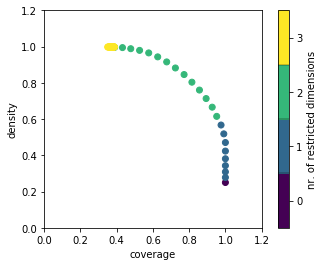

In [6]:
box1.show_tradeoff()
plt.show()

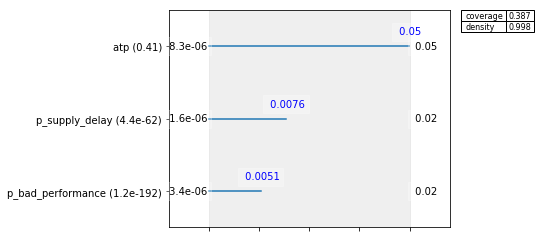

In [7]:
box1.inspect(style='graph')
plt.show()